# Ensemble Learning Model predicting each publication date
#### Import packages and data 

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
# Import packages
import numpy as np
import pandas as pd
import os
import warnings
import pickle

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import callbacks
from keras.models import load_model

from matplotlib.pyplot import show
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Your directory
os.chdir("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis")

# Define periodic prediction function
def periods_lags(df, y_variable, n_periods, n_lags, frequency):
    # Copy input data
    df_copy = df.copy()
    y = df_copy.loc[:, y_variable]
    name_ = y.name
    y_out = pd.DataFrame(y)
    
    # Drop y-variable from dataframe
    df_copy.drop(columns = [y_variable], inplace = True)
    
    # Create periodic y-variables
    for period in range(n_periods + 1):
        name = name_ + "_period_" + str(period)
        add_period = y.pct_change(period + 1)
        add_period = add_period.shift(-period)
        y_out = pd.concat([y_out, add_period.rename(name)], axis = 1)
    
    # Create lags of y-variables
    for lag in range(1, n_lags + 1):
        name = name_ + "_for_pred_lag_" + str(lag)
        add_lag = y.shift(lag)
        df_copy[name] = add_lag
        
    # Make sure X and y are of equal index
    y_out.replace(to_replace = np.nan, value = 0, inplace = True)
    index = list(set(df_copy.dropna().index) & set(y_out.index))
    X = df_copy.loc[index, :]
    y = y_out.loc[index, :]
    X.sort_index(inplace = True)
    y.sort_index(inplace = True)
    
    return X, y

# User inputs
n_periods = 4
n_lags = 1
frequency = 1
    
df_dict = {}
folio_rate = pd.read_excel("Data/base_models_predictions_pdates.xlsx", index_col = 0, parse_dates = True)
lag = folio_rate.pct_change().shift(1).replace(np.nan, 0)
lag.drop(index = lag.index[0], inplace = True)
for i in range(n_periods + 1):
    df = pd.read_excel("Data/base_models_pred_pdates_{}.xlsx".format(i), index_col = 0, parse_dates = True)
    lag = folio_rate.pct_change(1).shift(1).replace(np.nan, 0)
    lag_ = lag.loc[df.index[0]:]
    lag_.columns = ["folio_lag"]
    df = pd.concat([df, lag_], axis = 1)
    df_dict["base_pred_{}".format(i)] = df
folio_rate = pd.read_excel("Data/base_models_predictions_pdates.xlsx", index_col = 0, parse_dates = True)
pub_dates = folio_rate.copy()

print("Data succesfully imported. Shape of X = {}, y = {}".format(df.shape, folio_rate.shape))

Data succesfully imported. Shape of X = (99, 12), y = (161, 1)


#### Modeling

In [12]:
# Indicate font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size":15
})

In [5]:
# Create periodic y-variables
y, y_out = folio_rate.copy(), folio_rate.copy()
for period in range(n_periods + 1):
    name = y.columns[0] + "_{}".format(period)
    add_period = y.pct_change(period + 1)
    add_period = add_period.shift(-period)
    y_out = pd.concat([y_out, add_period.rename(columns = {"NO_folio_publication_date":name})], axis = 1)
y_out.drop(index = y_out.index[0], inplace = True)
y_out.replace(to_replace = np.nan, value = 0, inplace = True)
y_out = y_out.loc[df_dict["base_pred_0"].index, :]

# Train-test split
X_train_dic, X_test_dic, y_train_dic, y_test_dic = {}, {}, {}, {}
for i in range(n_periods + 1):
    X_train_dic["X_train_{}".format(i)], X_test_dic["X_test_{}".format(i)], y_train_dic["y_train_{}".format(i)], y_test_dic["y_test_{}".format(i)] = tts(df_dict["base_pred_{}".format(i)], y_out.iloc[:, i + 1], test_size = 0.32, shuffle = False, random_state = None)

In [6]:
def tscv_multi(n_splits, X_train, y_train, X_test, y_test):
    warnings.filterwarnings('ignore')

    # Define alphas and lambdas for grid search
    alphas = np.arange(0, 1, 0.1)
    lambdas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

    # Cross validations
    tscv = TimeSeriesSplit(n_splits = n_splits, test_size = None)

    # Construct model with k-fold cross validation for comparison
    model_tscv = ElasticNetCV(l1_ratio = alphas,
                            alphas = lambdas,
                            cv = tscv,
                            n_jobs = -1,
                            verbose = 0
                            )

    # Fit the models
    models = dict()
    alphas = list()
    lambdas = list()
    mse_paths = list()
    is_predictions = pd.DataFrame()
    oos_predictions = pd.DataFrame()
    mse_s = dict()
    coefs = dict()
    for period in range(5):
        model = model_tscv
        
        # Get correct x and y
        X_train_ex = X_train["X_train_{}".format(period)]
        X_test_ex = X_test["X_test_{}".format(period)]
        y_train_ex = y_train["y_train_{}".format(period)]
        y_test_ex = y_test["y_test_{}".format(period)]
        
        # Remove nans for y-variables and slice X
        y_train_, y_test_ = y_train_ex.dropna(), y_test_ex.dropna()
        train_index, test_index = y_train_.index, y_test_.index
        X_test_, X_train_ = X_test_ex.loc[test_index, :], X_train_ex.loc[train_index, :]
        
        # Fit model
        model.fit(X_train_, y_train_)

        # Save predictions and errors
        is_pred_tscv = pd.Series(model.predict(X_train_), index = train_index).rename("y_is_pred_{}".format(period))
        oos_pred_tscv = pd.Series(model.predict(X_test_), index = test_index).rename("y_oos_pred_{}".format(period))
        mse_tscv = [mse(y_train_, is_pred_tscv, squared = False), mse(y_test_, oos_pred_tscv, squared = False)]
        
        # Save outputs
        models["tscv_period_{}".format(period)] = model
        alphas.append(model.l1_ratio_)
        lambdas.append(model.alpha_)
        mse_paths.append(model.mse_path_)
        is_predictions = pd.concat([is_predictions, is_pred_tscv], axis = 1)
        oos_predictions = pd.concat([oos_predictions, oos_pred_tscv], axis = 1)
        mse_s["tscv_mse_period_{}".format(period)] = mse_tscv
        coefs["coefs_period_{}".format(period)] = pd.DataFrame(zip(model.coef_, df.columns), columns = ["value_coef", "variable"])
        coefs["coefs_period_{}".format(period)].loc[len(coefs["coefs_period_{}".format(period)]), :] = [model.intercept_, "Intercept"]
        
    # Output
    warnings.resetwarnings()
    
    return alphas, lambdas, mse_paths, is_predictions, oos_predictions, mse_s, coefs

alphas_, lambdas_, mse_paths_, tscv_is, tscv_oos, tscv_mse_s, coefs_ = tscv_multi(3, X_train_dic, y_train_dic, X_test_dic, y_test_dic)

#### Plot the results

In [7]:
# === Create a full timeline of predictions vs. actual values ===
# Actual values
y_is = (1 + tscv_is).multiply(pub_dates.shift(1).loc[tscv_is.index, :].dropna().values, axis = 0)
y_oos = (1 + tscv_oos).multiply(pub_dates.shift(1).loc[tscv_oos.index].values, axis = 0).dropna()
y_act = (1 + y_out.iloc[:, 1:]).multiply(pub_dates.shift(1).loc[y_out.index[0]:, :].dropna().values, axis = 0)
plotting = pd.concat([y_act, y_is, y_oos], axis = 1)

# Weights of models
#meta_model = tscv_models["tscv_period_0"]
weights = coefs_["coefs_period_0"].set_index("variable")
weights.sort_values(by = "value_coef", ascending = True, inplace = True)

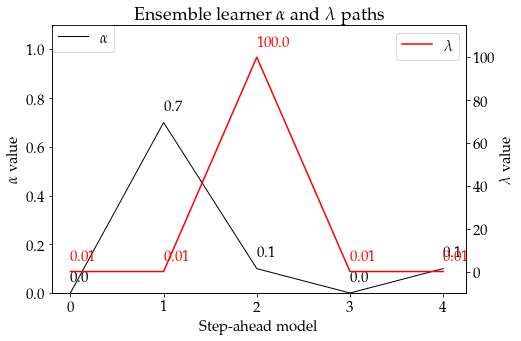

In [14]:
plt.figure(figsize = (7.5, 5))
plt.plot(alphas_, color = "black", label = r"$\alpha$", linewidth = 1)
for n, i in enumerate(alphas_):
    plt.text(x = n, y = i + 0.05, s = round(i, 2), color = "black", fontdict = {"weight":"heavy"})

plt.ylabel(r"$\alpha$ value")
plt.xlabel("Step-ahead model")
plt.legend(loc = (0, 0.9))
plt.ylim(bottom = 0, top = 1.1)
plt.xlim(right = 4.25)
plt.xticks(np.arange(5))
    
plt.twinx()

plt.plot(lambdas_, color = "red", label = r"$\lambda$")
for n, i in enumerate(lambdas_):
    plt.text(x = n, y = i + 5, s = round(i, 4), color = "red", fontdict = {"weight":"heavy"})

plt.ylabel(r"$\lambda$ value")
plt.xlabel("Step-ahead model")
plt.title(r"Ensemble learner $\alpha$ and $\lambda$ paths")
plt.legend()
plt.ylim(bottom = -10, top = 115)
plt.xlim(right = 4.25)
plt.xticks(np.arange(5))

plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/elpath.pgf")

In [9]:
names_pretty = {
    "Linear Regression":"linear_regression",
    "Elastic Net":"elastic_net",
    "K-Nearest Neighbors":"k_nearest_neighbors",
    "Decision Tree":"decision_tree_regressor",
    "Ada Boost":"ada_boost_regressor",
    "Bagging":"bagging_regressor",
    "Random Forest":"random_forest",
    "Extra Trees":"extra_trees",
    "Deep Neural Network":"neural_network",
    "Convolutional Neural Network":"convolutional_neural_network",
    "LSTM":"lstm",
    "Folio Rate Lag":"folio_lag",
    "Intercept":"Intercept"
}
names_pretty = {y:x for x,y in names_pretty.items()}
colors = {
    "Linear Regression":"black",
    "Elastic Net":"darkslategrey",
    "K-Nearest Neighbors":"slategrey",
    "Decision Tree":"navy",
    "Ada Boost":"royalblue",
    "Bagging":"steelblue",
    "Random Forest":"skyblue",
    "Extra Trees":"paleturquoise",
    "Deep Neural Network":"darkgreen",
    "Convolutional Neural Network":"forestgreen",
    "LSTM":"mediumaquamarine",
    "Folio Rate Lag":"darkslateblue",
    "Intercept":"indigo"
}

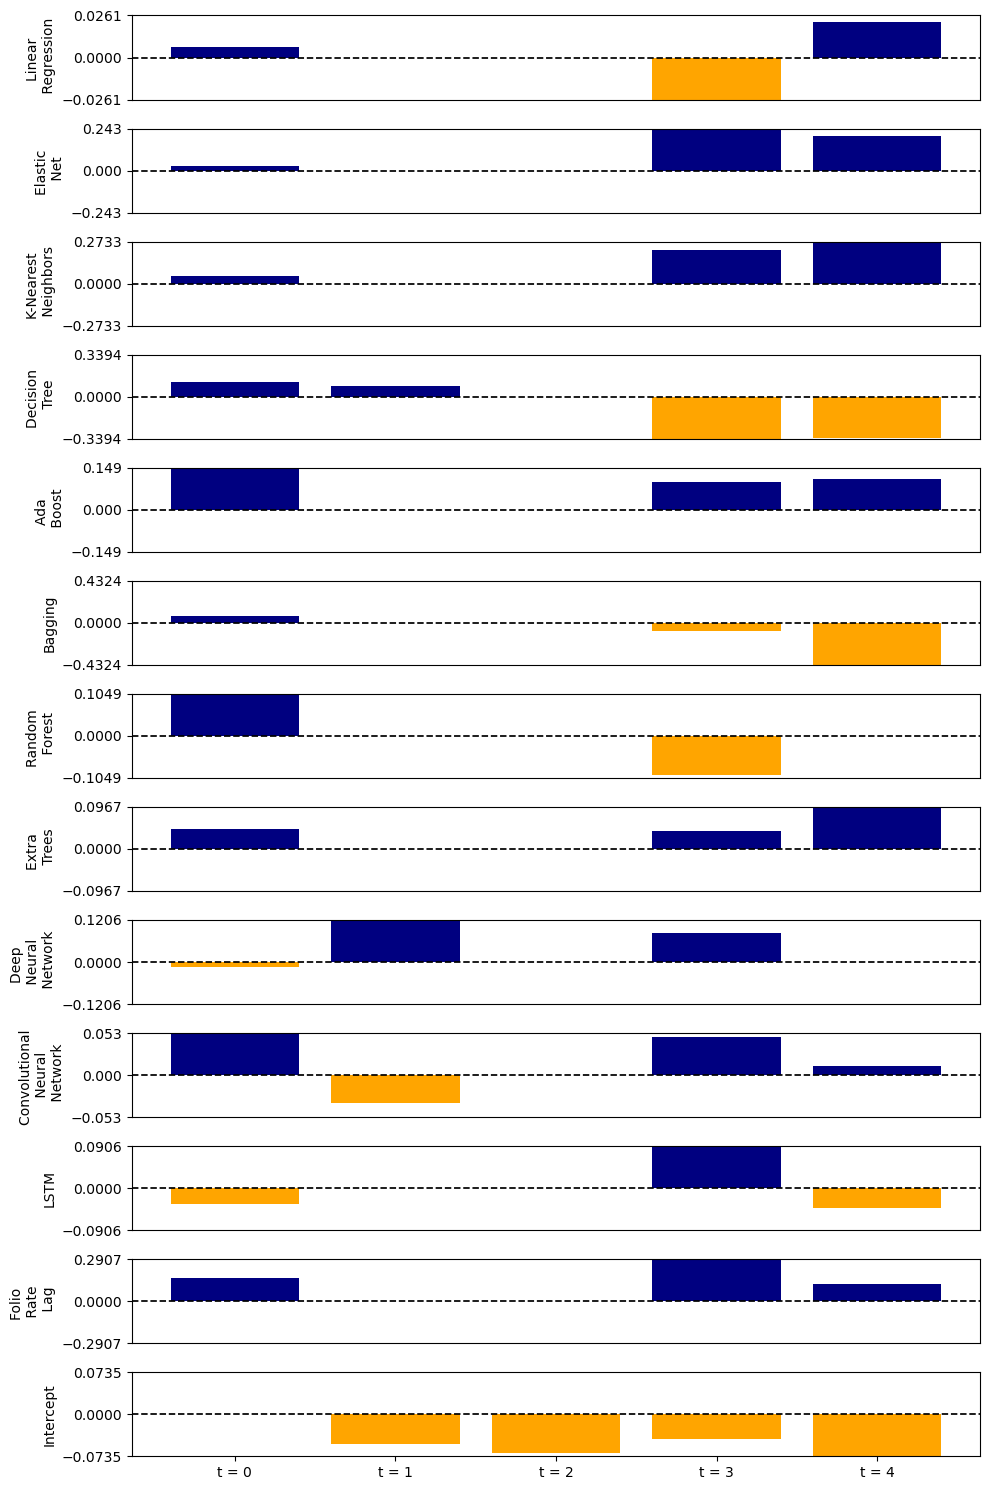

In [16]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

weights = coefs_["coefs_period_0"].copy()
for i in range(len(weights)):
    weights.loc[i, "mapping"] = names_pretty[weights.loc[i, "variable"]]

weights.set_index("mapping", inplace = True)
weights.index.name = None
weights.drop(columns = ["variable"], inplace = True)
weights.columns = ["t = 0"]

for i in range(1, len(coefs_)):
    ex = coefs_["coefs_period_{}".format(i)].copy()
    ex.set_index("variable", inplace = True)
    for model in ex.index:
        weights.loc[names_pretty[model], "t = {}".format(i)] = ex.loc[model, :].item()

map_ = {
    1:"navy",
    0:"grey",
    -1:"orange"
}    
plt.figure(figsize = (10, 15))
for plot in range(len(weights)):
    plt.subplot2grid(shape = (len(weights), 1), loc = (plot, 0))
    entry = weights.iloc[plot, :].values.reshape(-1)
    signs = list(np.sign(entry))
    colors = [map_[x] for x in signs]
    plt.bar(
        x = weights.columns,
        height = entry,
        bottom = 0,
        color = colors
    )
    if plot != len(weights) - 1:
        plt.xticks([])
    plt.axhline(y = 0, linestyle = "--", linewidth = 1.25, color = "black")
    #plt.box(on = False)
    if np.sign(max(entry, key = abs)) == 1:
        plt.ylim(top = max(entry), bottom = -max(entry))
        plt.yticks(ticks = [round(max(entry), 4), 0.0000, round(-max(entry), 4)])
    else:
        plt.ylim(top = -min(entry), bottom = min(entry))
        plt.yticks(ticks = [round(-min(entry), 4), 0.0000, round(min(entry), 4)])
    name = " \n ".join(weights.index[plot].split(" "))
    plt.ylabel(name)
    #plt.tick_params(axis='y', labelleft='off', labelright='off')

plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/en.pgf")

In [11]:
for n, i in enumerate(y_oos.columns):
    if i == "y_oos_pred_0":
        pass
    else:
        y_oos.loc[-n:, i] = np.nan

y_oos.to_excel("./Machine Learning Algorithms/Comparison/datasets/ensemble_predictions.xlsx")

<ipython-input-11-718b866803a9>:5: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  y_oos.loc[-n:, i] = np.nan
